In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader,random_split,Dataset
from torchvision import datasets,transforms,models
import cv2


In [ ]:
# Defining the transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resizes image to 224x224
    transforms.Grayscale(num_output_channels=3),  # Converts RGB to grayscale
    transforms.ToTensor(),  # Converts image to tensor value
])

In [ ]:
dataset=datasets.ImageFolder(root=r"C:\Users\Acer\Downloads\character_ocr",transform=transform) #loads the dataset from local storage

In [4]:
# Creating a DataLoader for the dataset
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [5]:
# Initializing variables to calculate mean and std
mean = 0.0
std = 0.0
total_images = 0

In [ ]:
# Looping through the dataset
for inputs, _ in data_loader:
    # Calculate batch mean and std
    batch_samples = inputs.size(0)  # Number of images in the batch
    inputs = inputs.view(batch_samples, inputs.size(1), -1)  # Flattens the images
    mean += inputs.mean(dim=2).mean(dim=0)  # Mean over width and height
    std += inputs.std(dim=2).std(dim=0)  # Std over width and height
    total_images += batch_samples

In [7]:
# Calculating the final mean and std
mean /= total_images
std /= total_images

In [8]:
transform_final = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Use dataset-specific mean and std
])

In [9]:
dataset = datasets.ImageFolder(
    root=r"C:\Users\Acer\Downloads\character_ocr",
    transform=transform_final
)

In [10]:
#defining training size and validation size
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size


In [11]:
# Splitting the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [12]:
#creating a custom dataset class to pair images with labels
class ImageDataset(Dataset):
    def __init__(self,images,labels):
        self.images=images
        self.labels= lables

    def __len__(self):
        return len(self.images)

    def __getitem__self(self,idx):
        image=self.images[idx]
        label=self.labels[idx]
        return iamge,label

In [13]:
#Cerating Dataloader for training and validation sets
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
#creating models
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        #defining the layers
        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1) #input=3; channels(RGB); output:32 channels
        self.pool=nn.MaxPool2d(2,2) #maxpooling with 2*2 filter
        self.conv2=nn.Conv2d(32,64, kernel_size=3,padding=1) # output:64 channels
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1) #output: 128 channels

        #droupout layer
        self.dropout=nn.Dropout(0.5) #Dropout for preventing from overfitting


        #Fully connected layer after flattening 
        self.fc1=nn.Linear(128*4*4,512) #Flattened size after two Maxpool (16*16 --> 4*4)
        self.fc2=nn.Linear(512, num_classes) #output layer with num_classes units
    
    def forward(self,x):
        #Applying Conv1, Relu and Maxpool
        x=self.pool(torch.relu(self.conv1(x)))

        x = self.dropout(x)  # Applying Dropout after Conv1 block

        #Applying Conv2, Relu and Maxpool
        x=self.pool(torch.relu(self.conv2(x)))

        #Applying Conv3, Relu and Maxpool
        x=self.pool(torch.relu(self.conv3(x)))

        #Flattning the output for fully connceted layers
        x=x.view(-1,128*4*4) #128 channels, 4*4 image size after pooling

        #Applying fully connected layers with Dropout 
        x=torch.relu(self.fc1(x))
        x=self.dropout(x) 
        x=self.fc2(x) # Output layer (no activation neede here, CrossEntropyloss does that)
        return x
        


Epoch [1/30] | Train Loss: 2.4500 | Val Loss: 0.8466 | Val Accuracy: 75.60% | Precision: 0.8093 | Recall: 0.7560 | F1 Score: 0.7634
Epoch [2/30] | Train Loss: 0.8939 | Val Loss: 0.5712 | Val Accuracy: 83.36% | Precision: 0.8211 | Recall: 0.7948 | F1 Score: 0.7984
Epoch [3/30] | Train Loss: 0.6913 | Val Loss: 0.3946 | Val Accuracy: 89.83% | Precision: 0.8419 | Recall: 0.8293 | F1 Score: 0.8309
Epoch [4/30] | Train Loss: 0.6063 | Val Loss: 0.4878 | Val Accuracy: 85.21% | Precision: 0.8470 | Recall: 0.8350 | F1 Score: 0.8363
Epoch [5/30] | Train Loss: 0.5713 | Val Loss: 0.2865 | Val Accuracy: 91.79% | Precision: 0.8597 | Recall: 0.8516 | F1 Score: 0.8524
Epoch [6/30] | Train Loss: 0.5693 | Val Loss: 0.3248 | Val Accuracy: 92.22% | Precision: 0.8690 | Recall: 0.8634 | F1 Score: 0.8638
Epoch [7/30] | Train Loss: 0.5233 | Val Loss: 0.3320 | Val Accuracy: 90.90% | Precision: 0.8741 | Recall: 0.8699 | F1 Score: 0.8702
Epoch [8/30] | Train Loss: 0.5226 | Val Loss: 0.2715 | Val Accuracy: 92.28% 

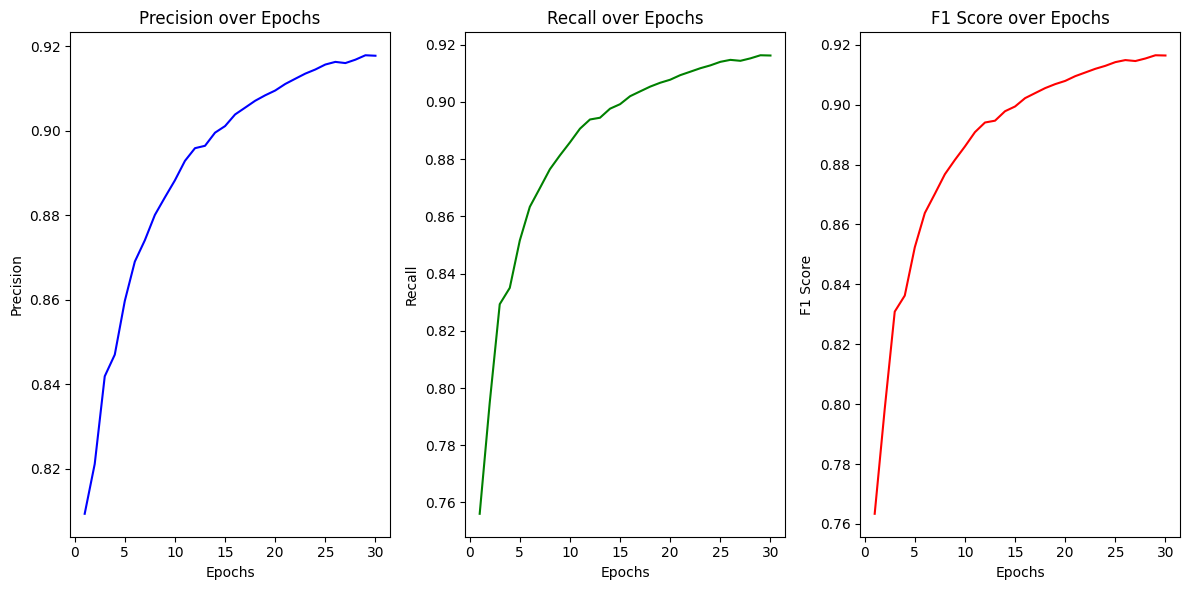

In [15]:
# Model initialization
input_size = 32
num_classes = 34
model = CNNModel(input_size=input_size, num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Loop
num_epochs = 30
best_val_loss = float('inf')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# To track metrics
all_val_labels = []
all_val_preds = []

# For storing precision, recall, and F1 score over epochs
precision_history = []
recall_history = []
f1_score_history = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()

    # Calculates average training loss
    avg_train_loss = running_loss / len(train_data)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_images, val_labels in val_data:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            # Forward pass
            val_outputs = model(val_images)

            # Loss calculation
            val_loss += criterion(val_outputs, val_labels).item()

            # Accuracy calculation
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

            # Collects all labels and predictions for precision, recall, and f1 calculation
            all_val_labels.extend(val_labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_data)
    val_accuracy = 100 * correct / total

    # Calculate precision, recall, and f1-score
    precision = precision_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
    recall = recall_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)

    # Store metrics
    precision_history.append(precision)
    recall_history.append(recall)
    f1_score_history.append(f1)

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss: 
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Accuracy: {val_accuracy:.2f}% | "
          f"Precision: {precision:.4f} | "
          f"Recall: {recall:.4f} | "
          f"F1 Score: {f1:.4f}")

# Plotting Precision, Recall, and F1 Score over Epochs
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs, precision_history, label='Precision', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision over Epochs')

plt.subplot(1, 3, 2)
plt.plot(epochs, recall_history, label='Recall', color='green')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall over Epochs')

plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score_history, label='F1 Score', color='red')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')

plt.tight_layout()
plt.show()

In [16]:
#model testing
from PIL import Image


In [17]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=mean, std=std)
])

In [18]:
# Function to preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")  # Open as grayscale
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    return image

In [19]:
# Function to test the model with a single image
def test_model(image_path, model, class_names):
    image = preprocess_image(image_path)  # Preprocess the image
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)  # Send image to the correct device
    model = model.to(device)  # Ensure the model is on the same device

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradient calculation needed
        outputs = model(image)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index

    return class_names[predicted.item()]  # Return the class name

In [24]:
# Test the trained model 
image_path = r"C:\Users\Acer\Downloads\character_ocr\८\८_6.jpg" 
class_names = dataset.classes 

In [25]:
# Perform the prediction
predicted_class = test_model(image_path, model, class_names)
print(f"The predicted class is: {predicted_class}")

The predicted class is: ८
